In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
from pathlib import Path
import PIL
import os
from time import gmtime, strftime


In [2]:
def show(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(img))
def show_plt(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [3]:
read_range = (3840,4060)
im_path = "data/North Cropped/"
#im_path = "light_enhancement/LIMEOutput/"
# for i in range(read_range[0], read_range[1]):
#     path = f"{im_path}{str(i)}.jpg"
#     img = cv2.imread(path)

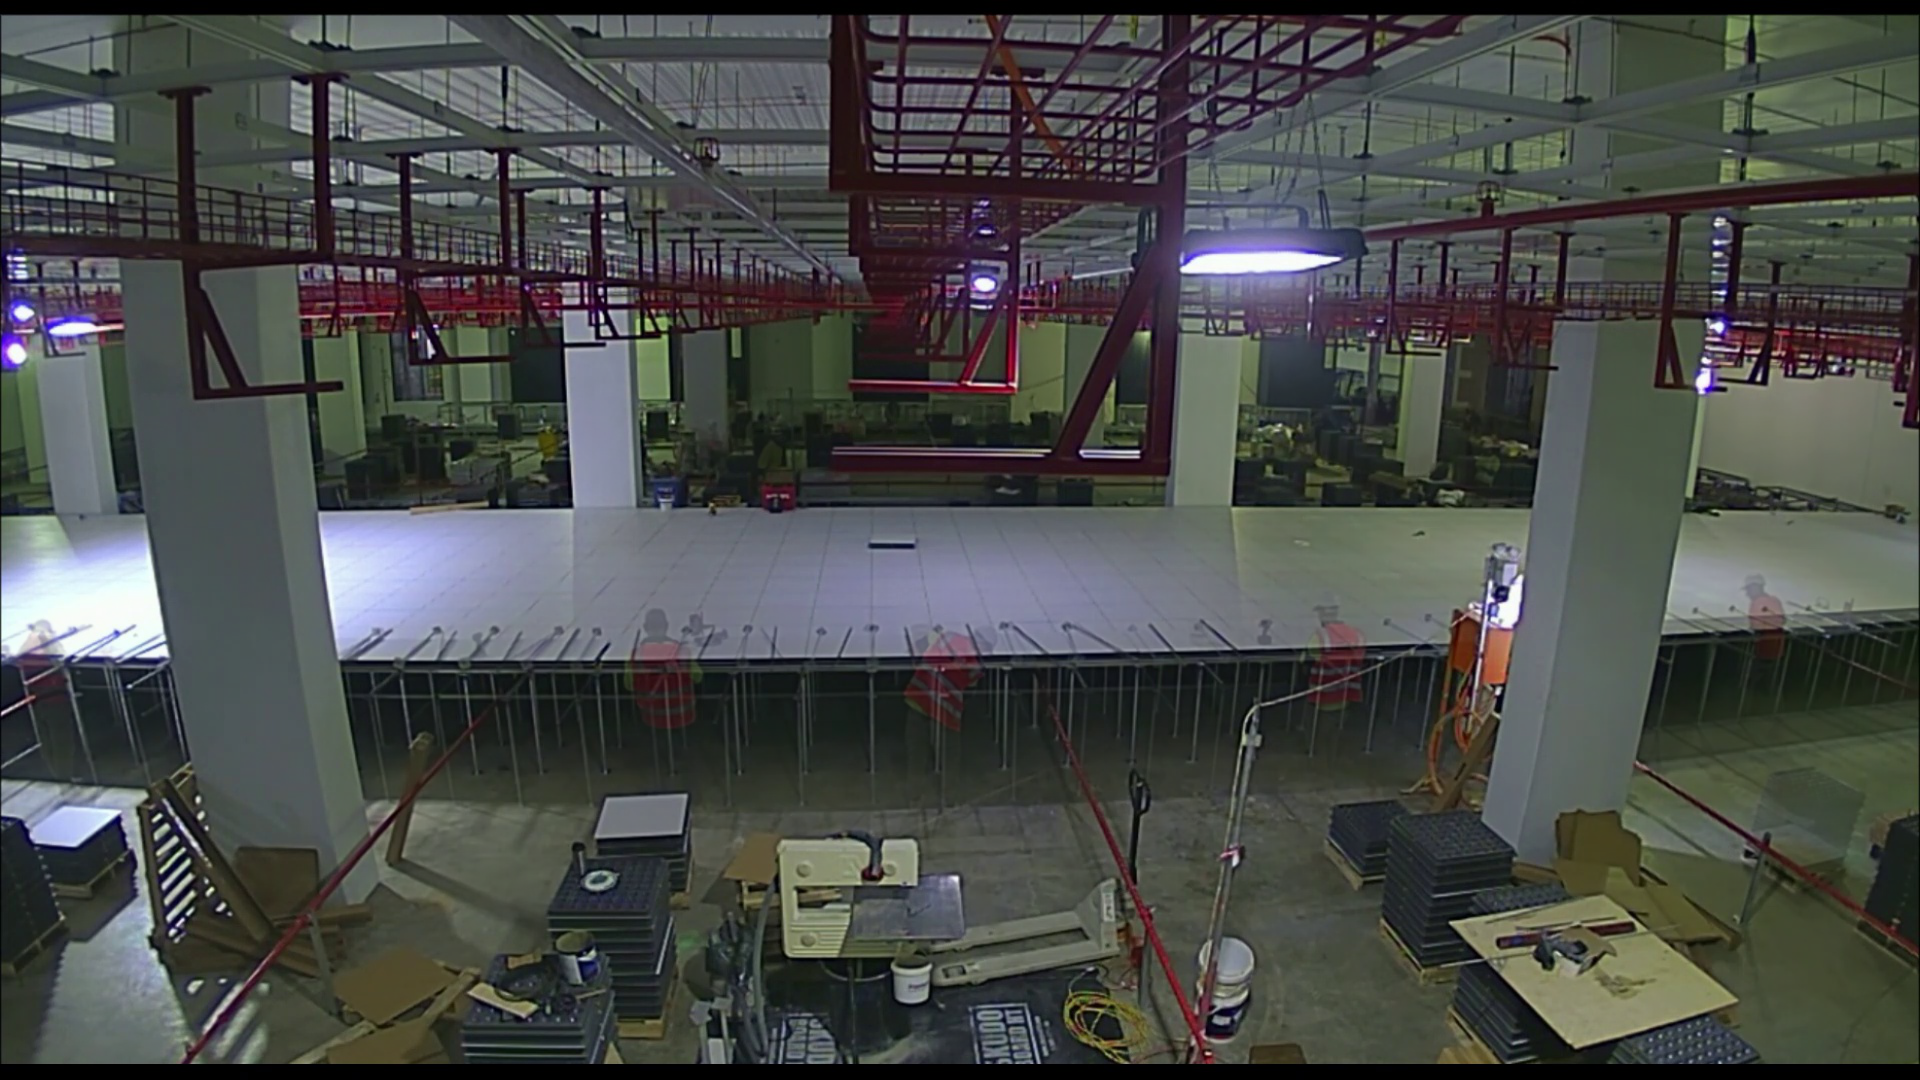

In [25]:
def get_average_image(image_list):
    sum1 = None
    sum2 = None
    rng = len(image_list)
    for i in range(rng):
        f1 = image_list[i]
        f1 = np.array(f1, dtype=np.float)
        if sum1 is None:
            sum1 = f1
        else:
            sum1 += f1
    ret = (sum1/rng).astype('uint8')
    return ret

def read_list(im_path, fromm, to):
    im_list = []
    for i in range(fromm, to):
        path=im_path+str(i)+".jpg"
        img = cv2.imread(path)
        if img is None:
            raise Exception("No such image: "+path)
        im_list.append(img)
        
    return im_list
fr = 3985
to = 3989
im_list = read_list(im_path, fr, to)
avg_img = get_average_image(im_list)
show(avg_img)

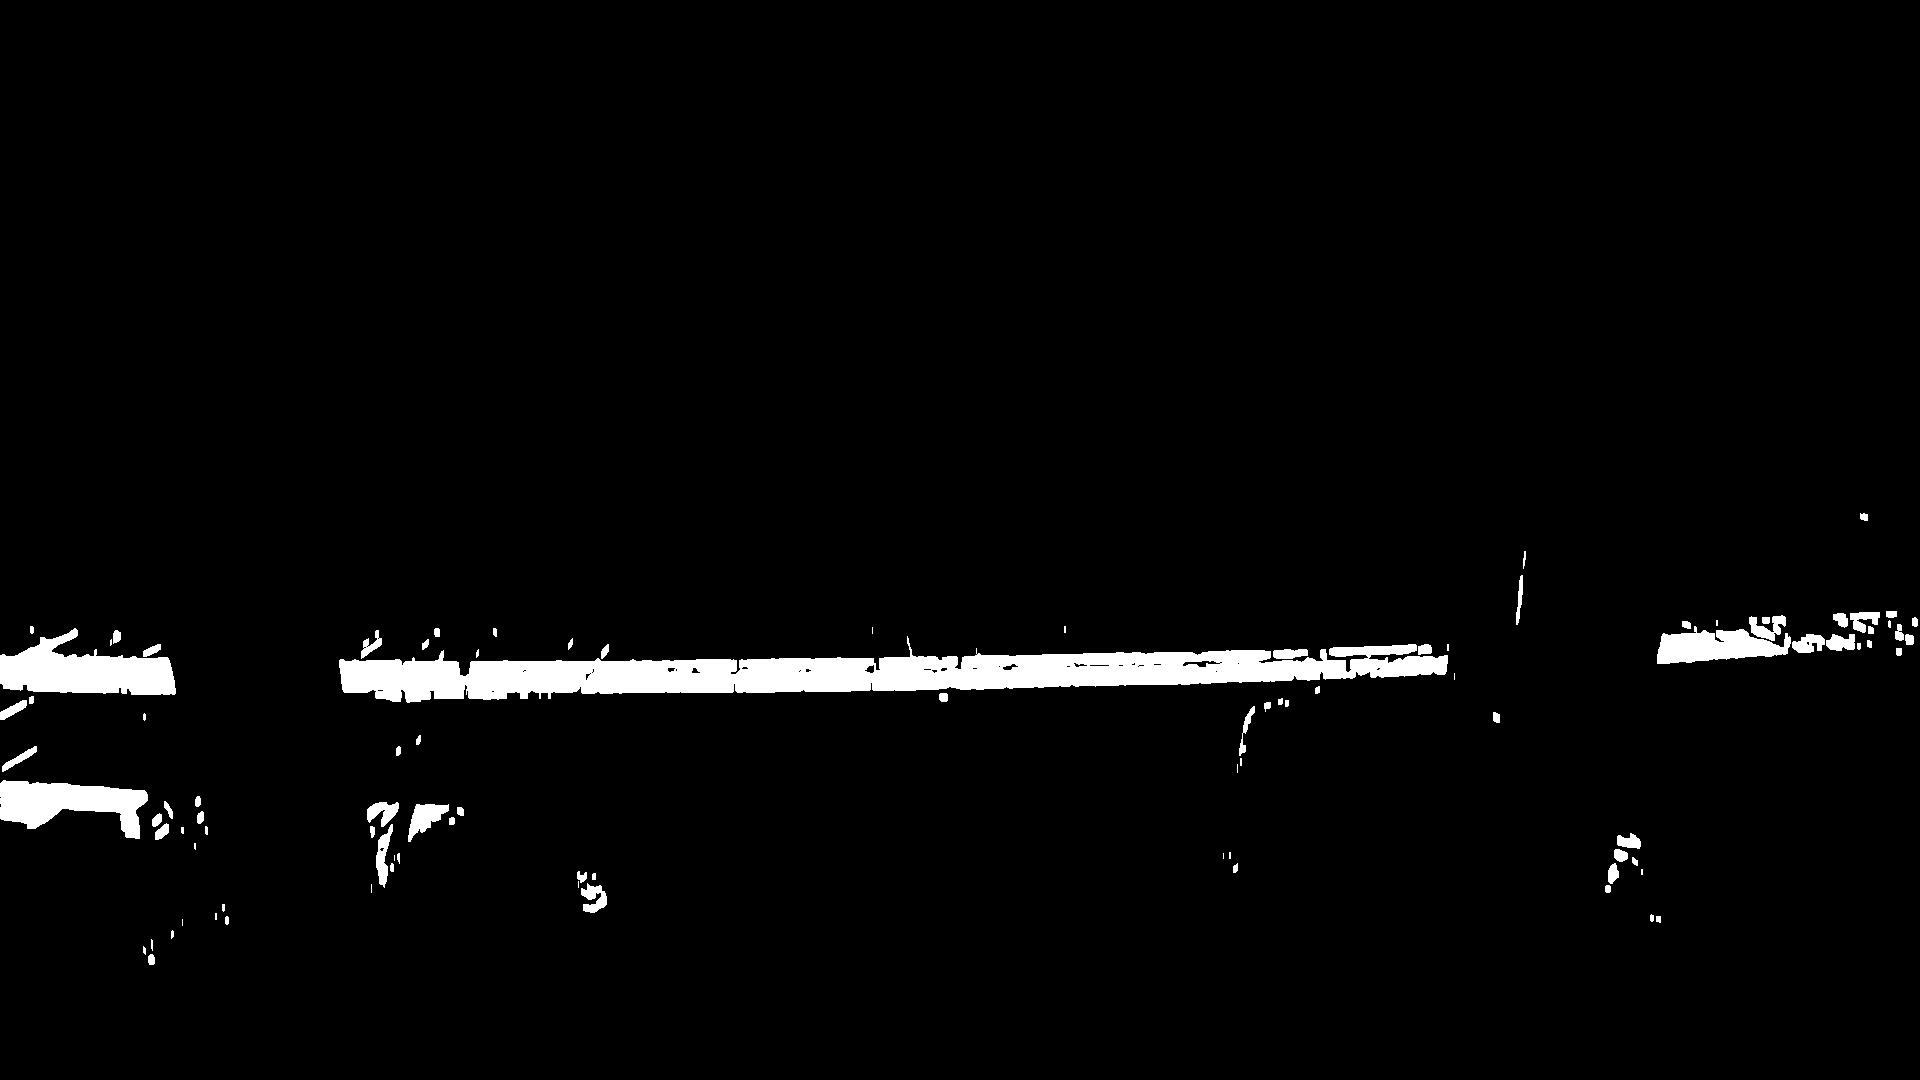

In [5]:
def diff(frame1,frame2):
    d = cv2.absdiff(frame1, frame2)
    grey = cv2.cvtColor(d, cv2.COLOR_BGR2GRAY)
    return grey
def thresh(gray, thrsh):
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    ret, th = cv2.threshold(blur, thrsh, 255, cv2.THRESH_BINARY)
    return th

im_list = read_list(im_path,3984, 3989)
avg_img = get_average_image(im_list)

im_list2 = read_list(im_path,3990, 3995)
avg_img2 = get_average_image(im_list2)

dif = diff(avg_img, avg_img2)
th = thresh(dif, 60)

th = cv2.dilate(th,np.array([10,10]),iterations = 5)
th = cv2.cvtColor(th, cv2.COLOR_GRAY2BGR)

show(th)
#cv2.imwrite("flow_results/LIME_threshold_improvement/beforeLIME2.jpg", th)

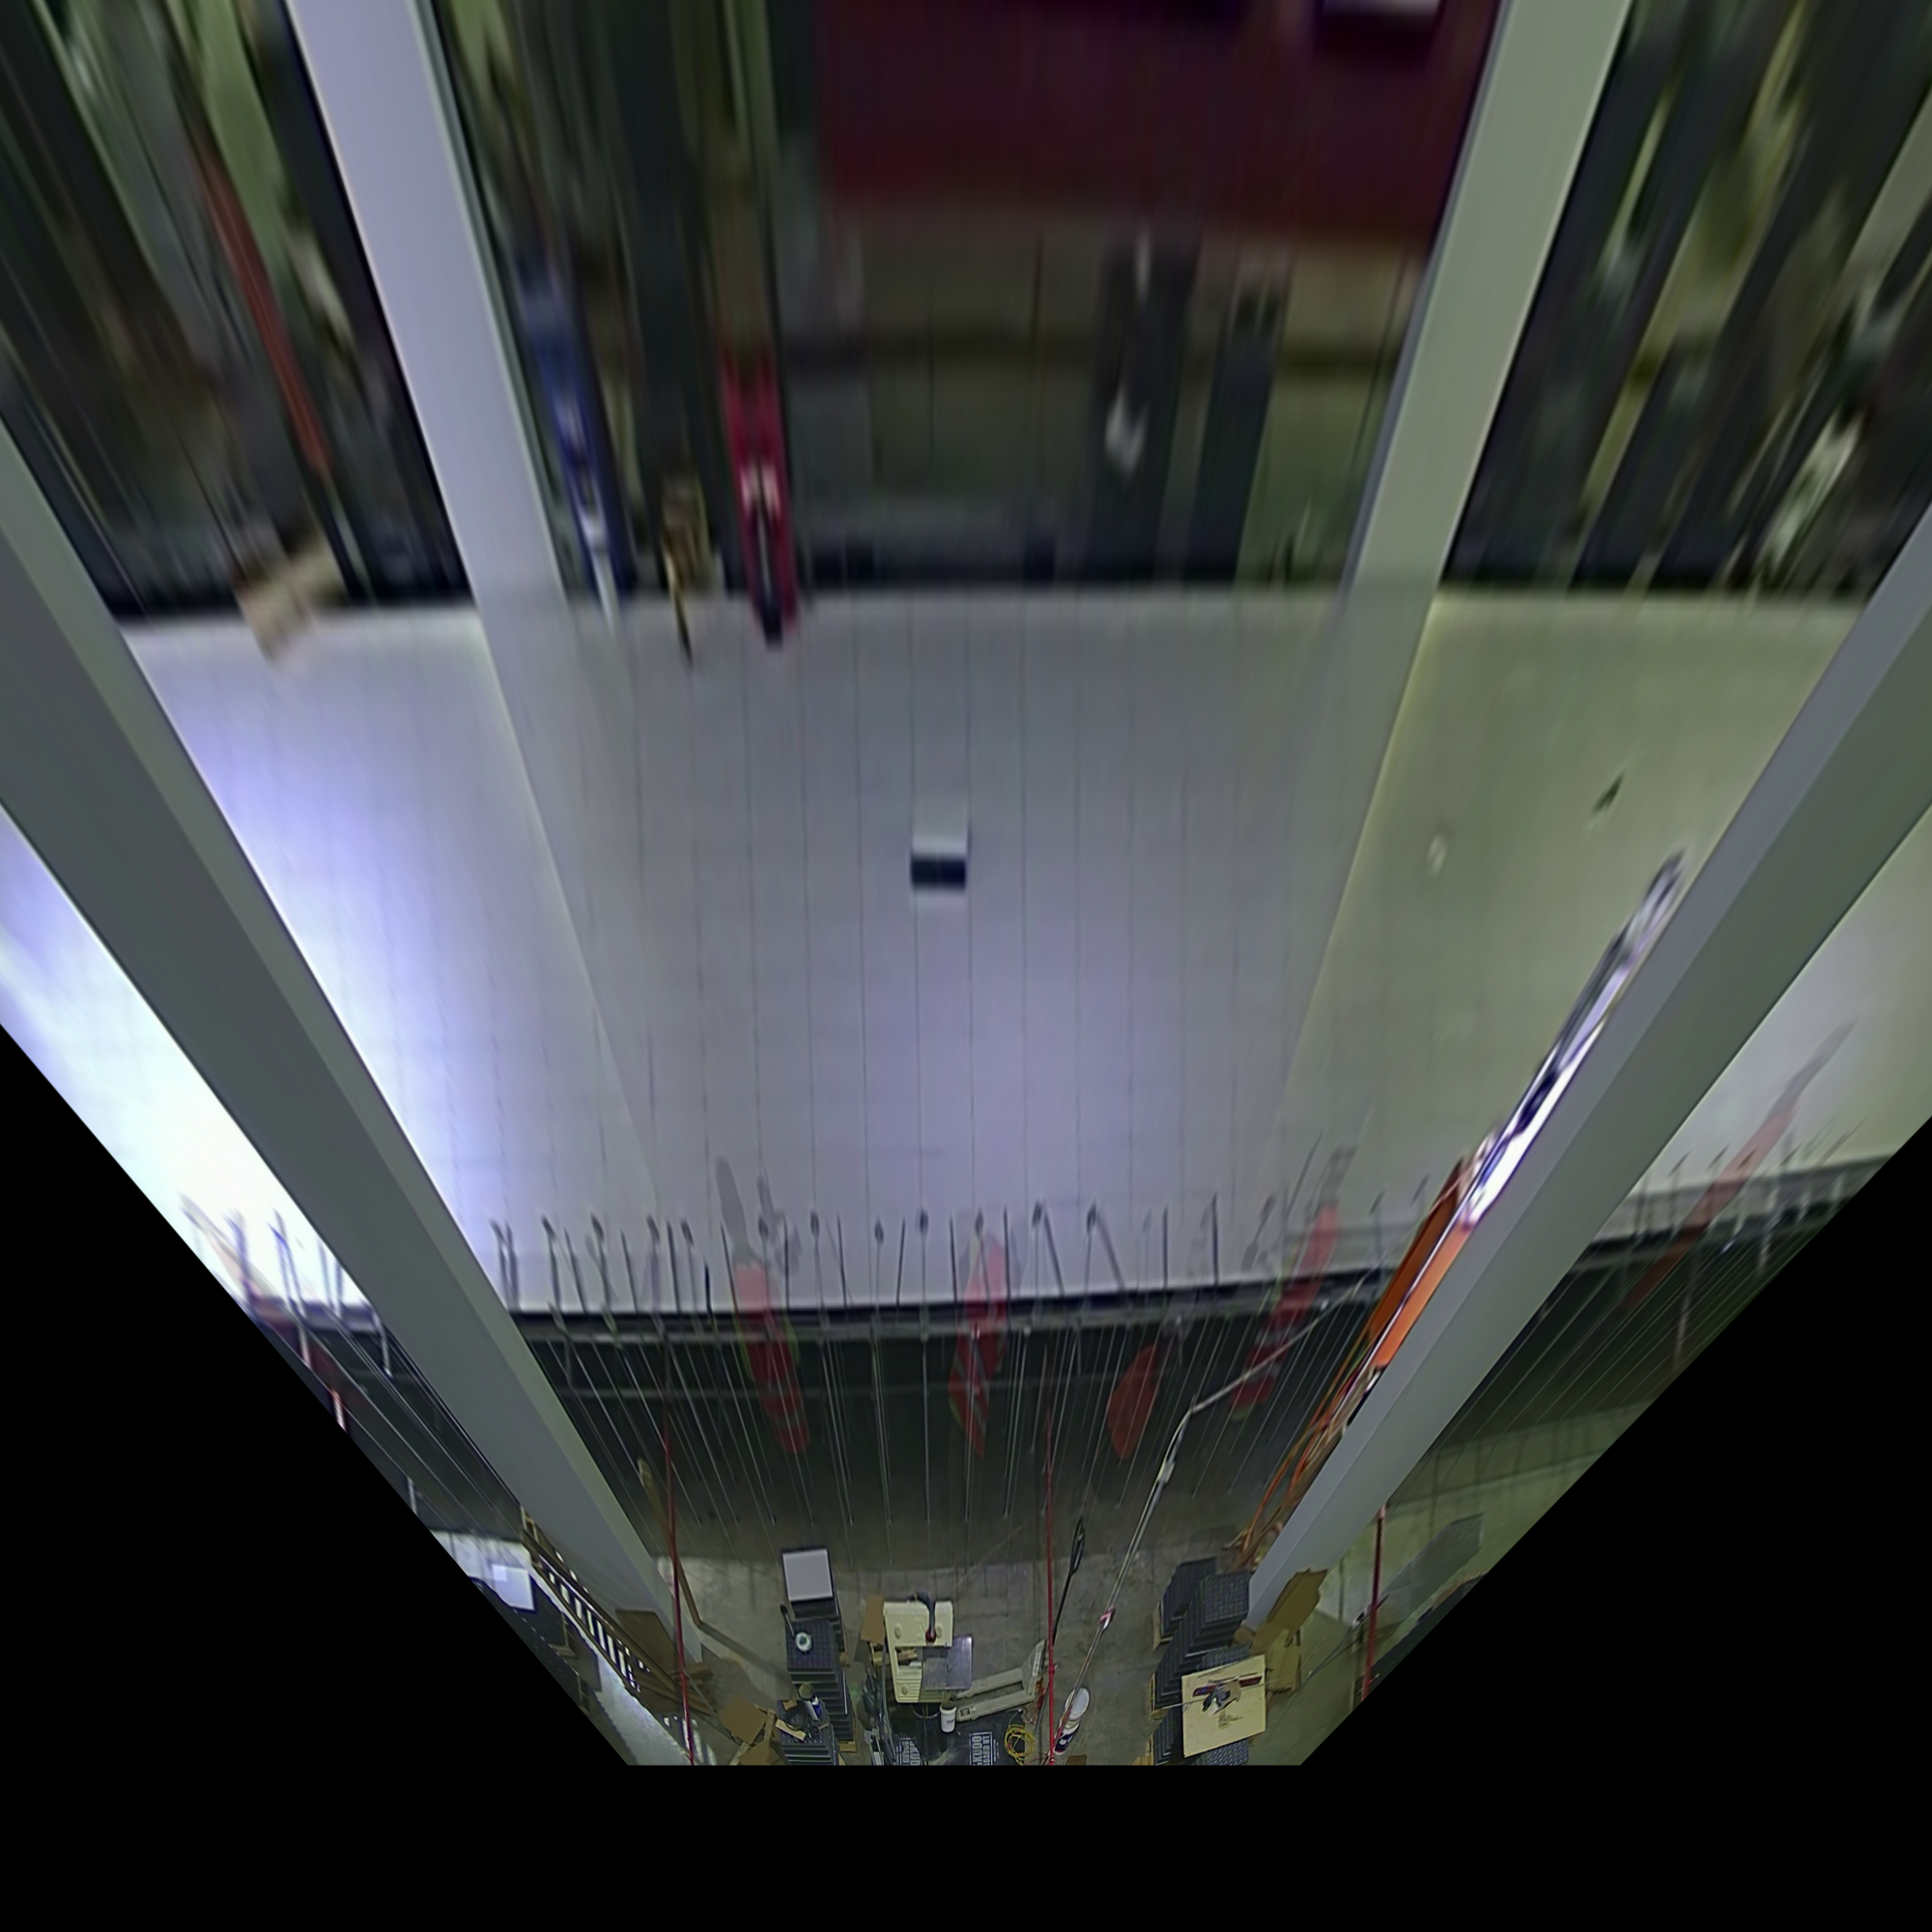

In [6]:
def getPerspectiveTransform(points, col_dis, output_size):
    startx = output_size[0] / 2 - col_dis[0]/2
    endx = output_size[0] / 2 + col_dis[0]/2

    starty = output_size[1] / 2 - col_dis[1]/2
    endy = output_size[1] / 2 + col_dis[1]/2

    targetPoints = [(startx, starty), (endx, starty), (startx, endy), (endx, endy)]

    empty_img = np.ones(output_size, dtype=np.uint8)
    
    pst1 = np.float32(points)
    pst2 = np.float32(targetPoints)
    '''
    A perspective transform relates two points in the following manner:  
    [x']   [m00 m01 m02] [x]
    [y'] = [m10 m11 m12] [y]
    [1]    [m20 m21 m22] [1]
    Where (x,y) are the original 2D point coordinates, and (x', y') are the transformed coordinates.
    '''
    matrix = cv2.getPerspectiveTransform(pst1, pst2)
    return matrix

points = [(640, 500), (1180, 500), (340, 700), (1520, 700)]
output_size =(2000,2000)
matrix = getPerspectiveTransform(points, (850,900), output_size)
avg_transformed = cv2.warpPerspective(avg_img, matrix, output_size)
show(avg_transformed)

In [7]:
def find_contours(bimg, min_size):
    img, c, h = cv2.findContours(bimg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c = [a for a in c if a.shape[0] > min_size]
    return c
# c = find_contours(th_transformed, 300)
# th_rgb = cv2.cvtColor(th_transformed, cv2.COLOR_BAYER_BG2BGR)
# cv2.drawContours(th_rgb, c, -1, (0, 255, 0), 2)
# show(th_rgb)
    

In [8]:
def contours_area_count(c):
    sum = 0
    for i in c:
        area = cv2.contourArea(i)
        sum += area
    return sum

# print(contours_area_count(c))

In [11]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
 
	# apply gamma correction using the lookup table
    
	return cv2.LUT(image, table)

def adjust_gamma_list(imagelist, gamma):
    retArr = []
    for i in imagelist:
        adj= adjust_gamma(i, gamma)
        retArr.append(adj)
    return retArr

In [31]:
import pandas as pd
df = pd.DataFrame({'Frame':[1,2,3], 'Area':[13,345,456564]})
df.head()

Frame    Area
0      1      13
1      2     345
2      3  456564

In [13]:
def saveImg(directory,i, img):
    Path(directory).mkdir(parents=True, exist_ok=True)
    path = directory+str(i)+".jpg"
    cv2.imwrite(path,img)
    return True

In [14]:
def draw(img, points):
    for p in points:
        cv2.circle(img, p, 10, (255, 0, 0), -1)

In [36]:
import time
def main():
    frame_numbers = []
    areas = []
    pathArr = []
    method = 'LIME'
    date = strftime("%Y-%m-%d %H:%M:%S", gmtime())
    threshold = 50
    min_area = 300
    avg_range = 5
    if method == "LIME":
        im_path = "data/After LIME/"
    else:
        im_path = "data/North Cropped/"
    for i in range(read_range[0], read_range[1]):
        tic = time.clock()
        sys.stdout.write("\r%f%%" % ((i+1-read_range[0])*100/(read_range[1] - read_range[0])))
        sys.stdout.flush()
        im_list = read_list(im_path, i-avg_range, i)
        im_list2 = read_list(im_path, i, i+avg_range)
        if method == 'gamma':
            im_list = adjust_gamma_list(im_list, 2.5)
            im_list2 = adjust_gamma_list(im_list2, 2.5)
        
        avg_img = get_average_image(im_list)
        avg_img2 = get_average_image(im_list2)
        
        points = [(640, 500), (1180, 500), (340, 700), (1520, 700)]
        output_size =(2000,2000)
        matrix = getPerspectiveTransform(points, (900,900), output_size)
        avg_transformed = cv2.warpPerspective(avg_img, matrix, output_size)
        avg2_transformed = cv2.warpPerspective(avg_img2, matrix, output_size)
       
        
        dif = diff(avg_transformed, avg2_transformed)
        
        th = thresh(dif, threshold)

        c = find_contours(th, min_area)
        area_count = contours_area_count(c)
        areas.append(area_count)
        frame_numbers.append(i)
        
        th_rgb = cv2.cvtColor(th, cv2.COLOR_BAYER_BG2BGR)
        cv2.drawContours(th_rgb, c, -1, (0, 0, 255), 2)
#         cv2.drawContours(avg2_transformed, c, -1, (0, 0, 255), 2)
        threshImgsDir = 'flow_results/'+f"{method} {date}"+"/thresh/"
        avgTransformedImgsDir = 'flow_results/'+f"{method} {date}"+"/avg_transformed/"
        avgImgsDir = 'flow_results/'+f"{method} {date}"+"/avg/"
        diffImgsDir = 'flow_results/'+f"{method} {date}"+"/diff/"
        saveImg(diffImgsDir, i, dif)
        saveImg(avgImgsDir, i, avg_img)
        saveImg(threshImgsDir, i, th_rgb)
        saveImg(avgTransformedImgsDir, i, avg2_transformed)
        pathArr.append(str(i)+'.jpg')
        toc = time.clock()

        
    df = pd.DataFrame({'Frame':frame_numbers, 'Area':areas, 'path': pathArr})
    csvPath = 'sheets/process_flow_'+f"{method} {date}"+'.csv'
    df.to_csv(csvPath, index=False)
main()

100.000000%